In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import Bargaining as brg

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

# c++ settings
do_cpp = True
do_compile = True
threads = 16

In [2]:
# compile c++ files
if do_cpp & do_compile:
    model = brg.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)

# Solve and simulate from alternative models

In [3]:
# settings for models to solve
T = 10
specs = {
    'model 1':{'latexname':'$\sigma_{\psi}=0$', 'par':{'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads}},
    'model 2':{'latexname':'$\sigma_{\psi}=0.04$', 'par':{'sigma_love':0.04,'T':T,'do_cpp':do_cpp,'threads':threads}},
    'model 3':{'latexname':'$\sigma_{\psi}=0.1$', 'par':{'sigma_love':0.1,'T':T,'do_cpp':do_cpp,'threads':threads}},
    'model 4':{'latexname':'$\kappa_w=0.3$', 'par':{'div_A_share':0.3,'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads}},
}


In [4]:
# solve different models
models = {}
for name,spec in specs.items():
    print(f'solving {name}...')
    
    # setup model
    models[name] = brg.HouseholdModelClass(name=name,par=spec['par'])
    if do_cpp: models[name].link_to_cpp(force_compile=False)
    models[name].spec = spec
    
    # solve
    models[name].solve()

solving model 1...
solving model 2...
solving model 3...
solving model 4...


# Simulated paths

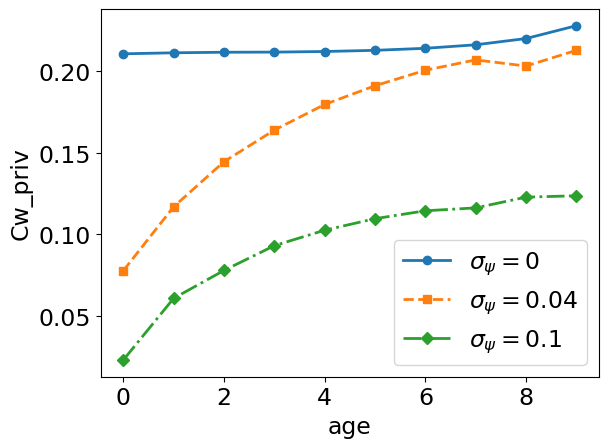

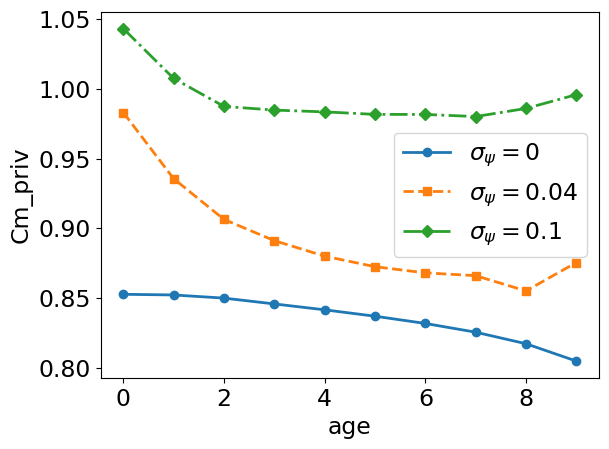

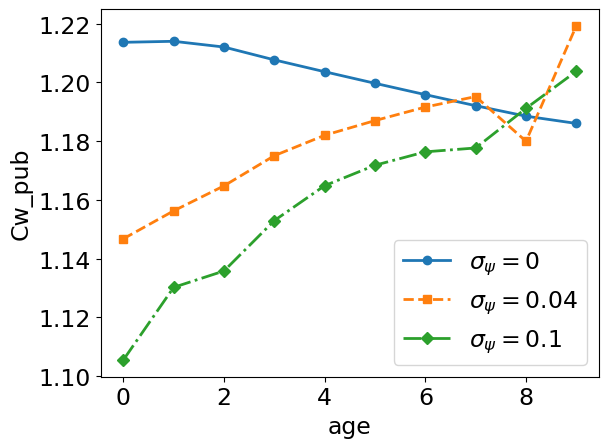

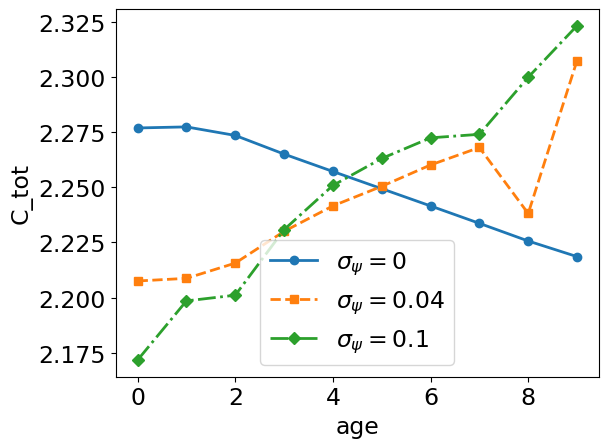

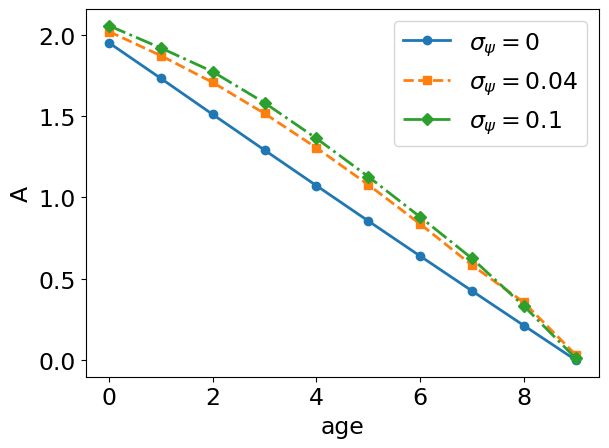

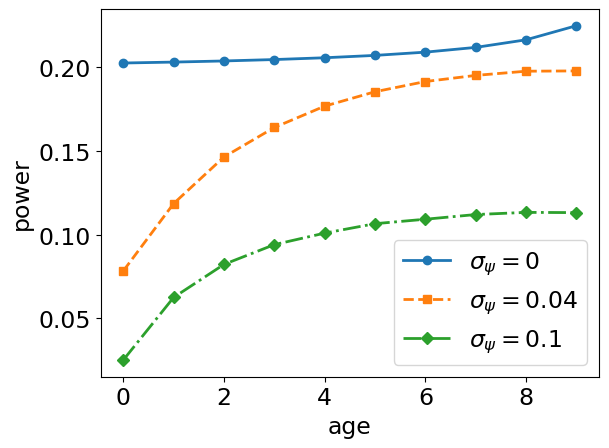

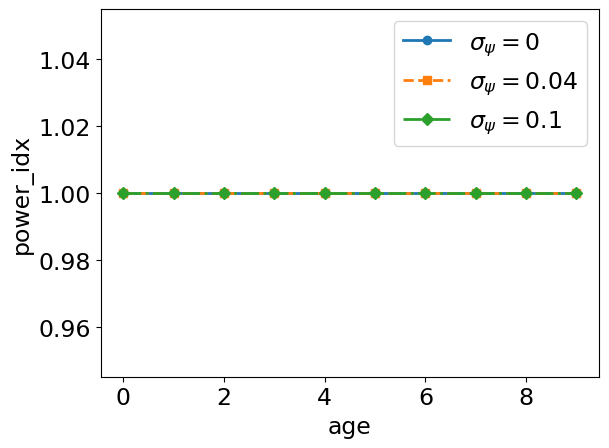

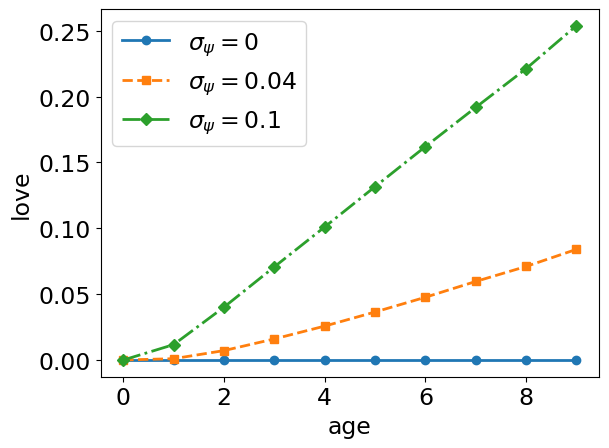

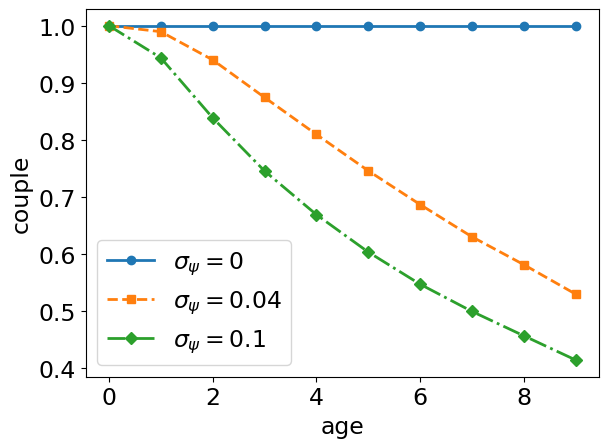

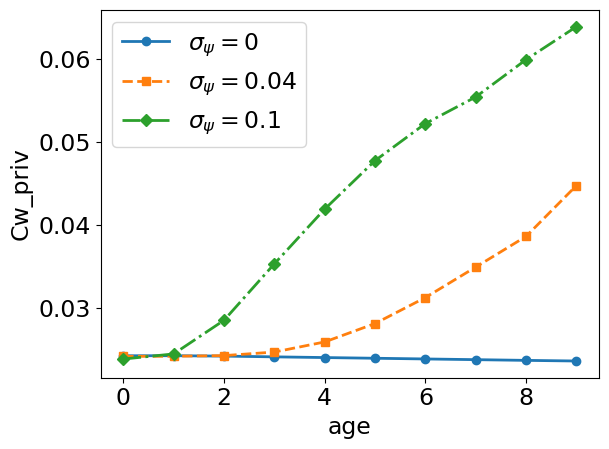

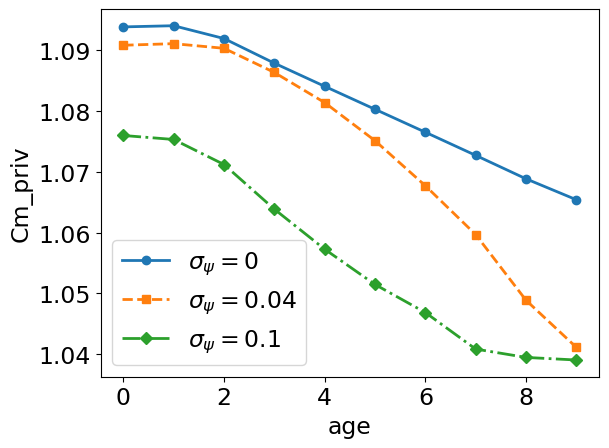

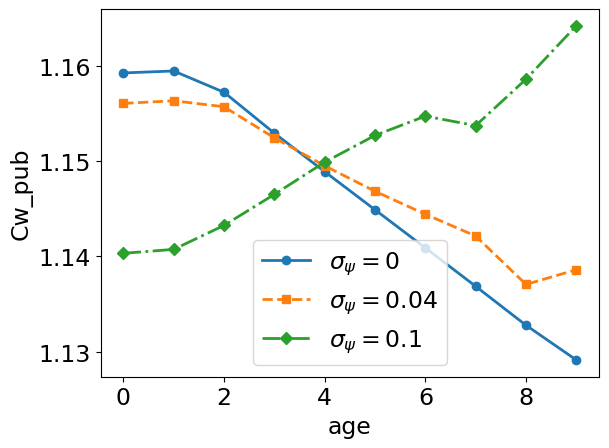

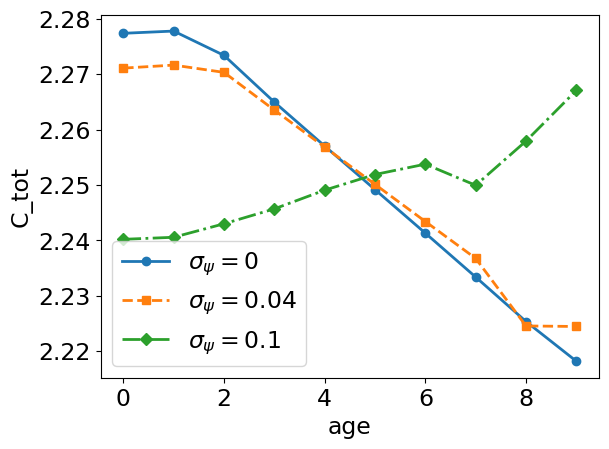

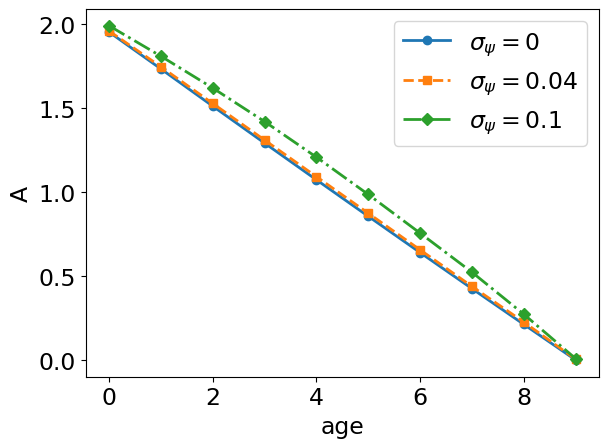

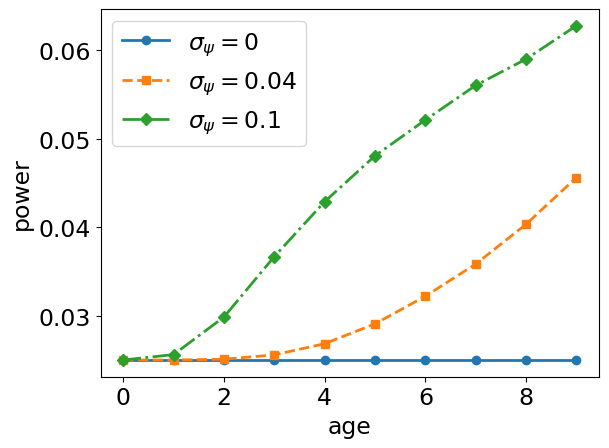

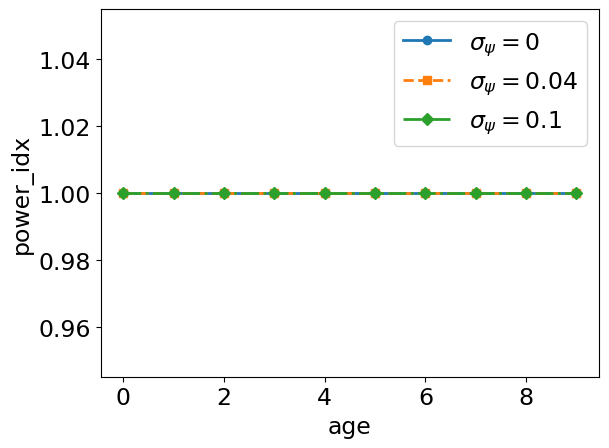

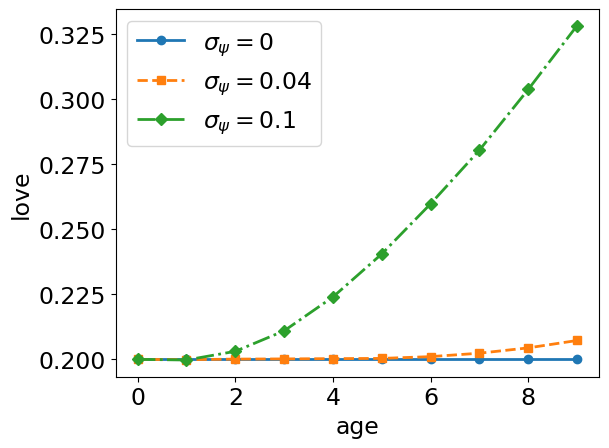

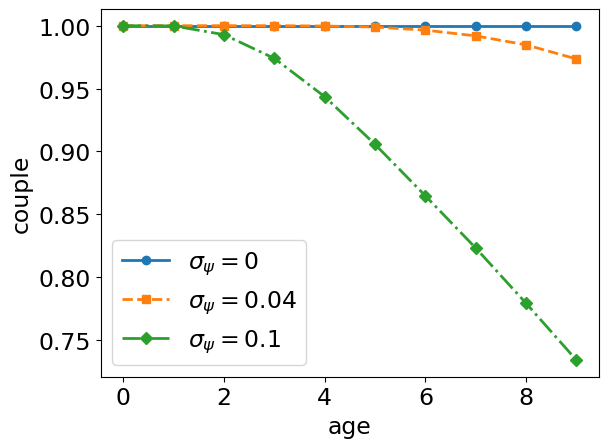

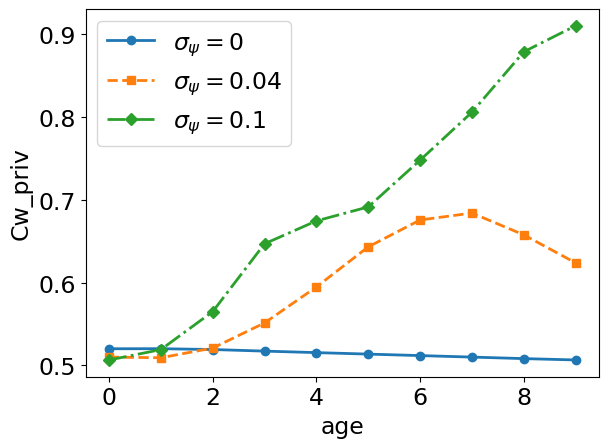

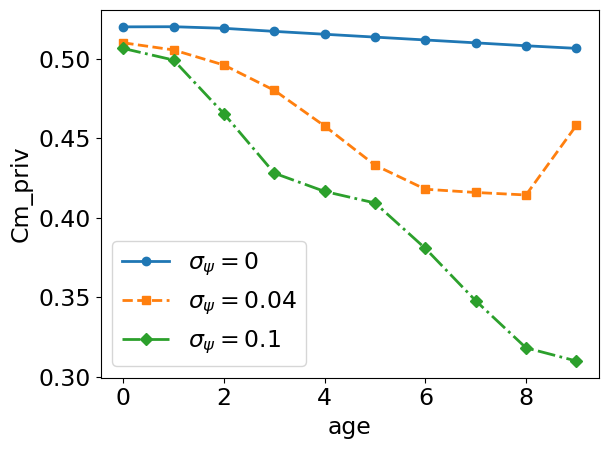

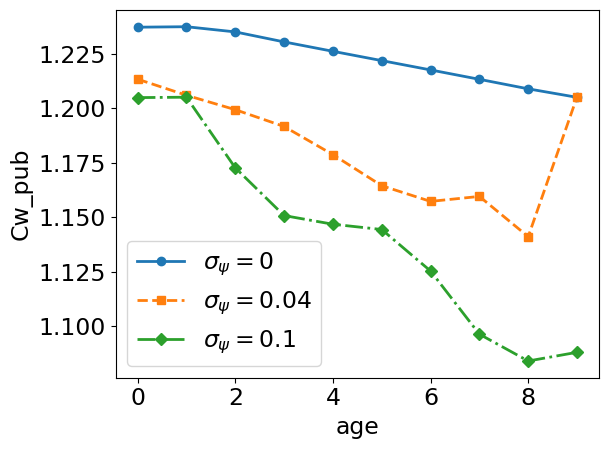

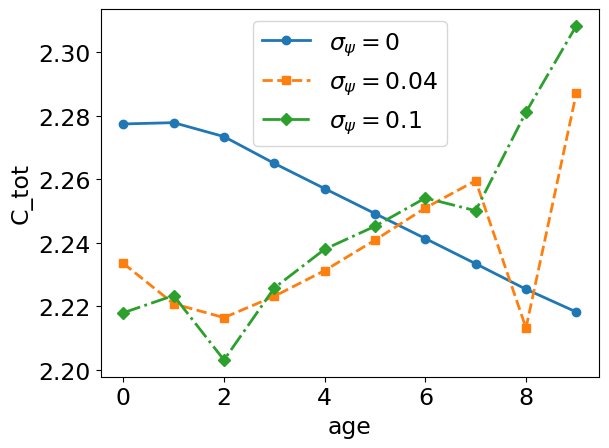

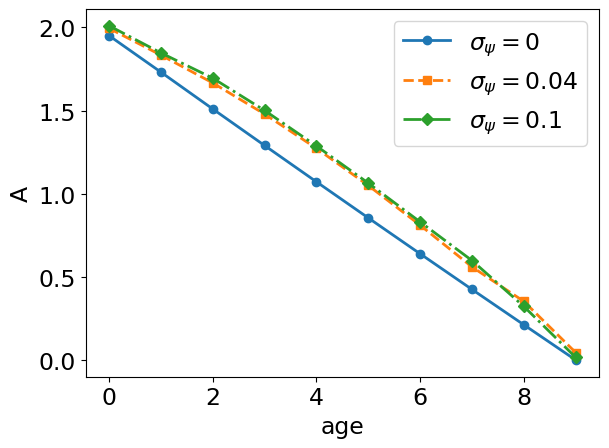

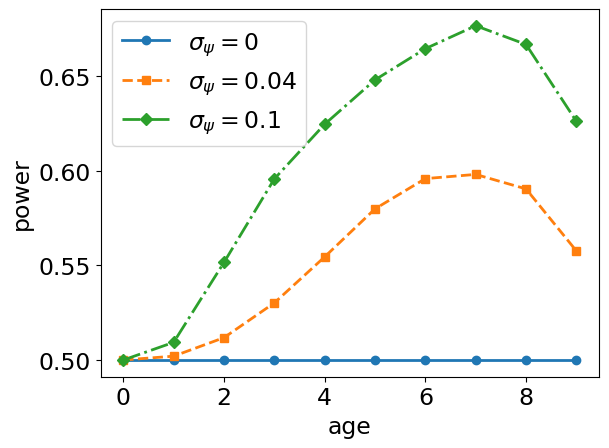

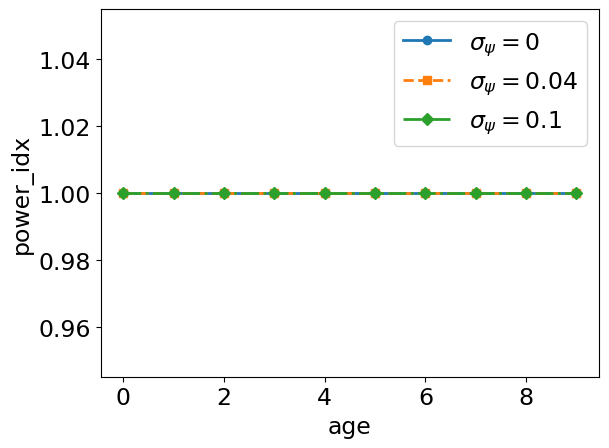

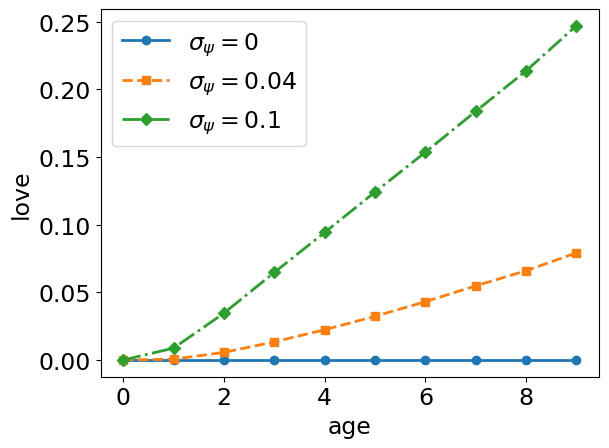

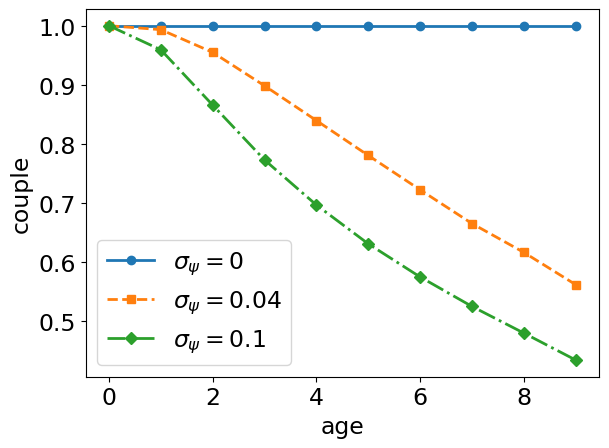

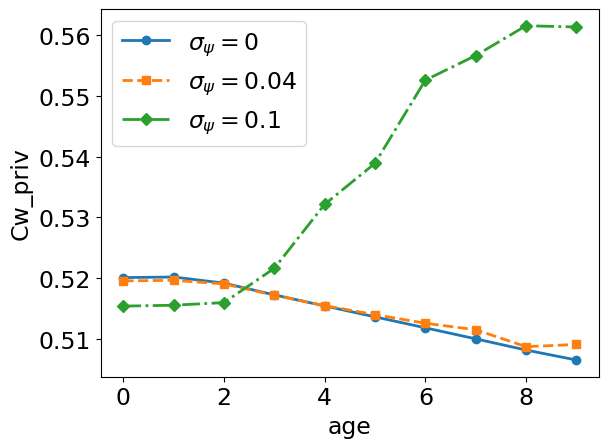

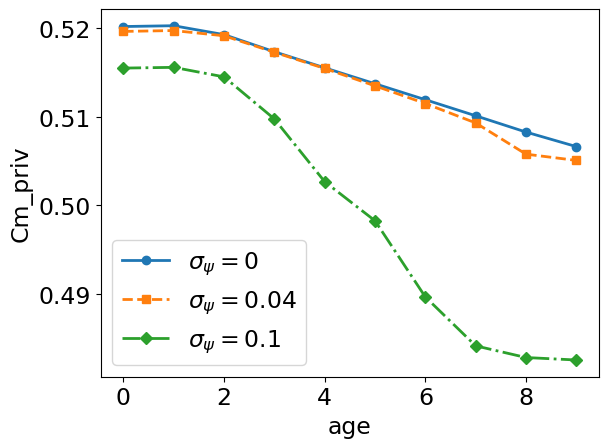

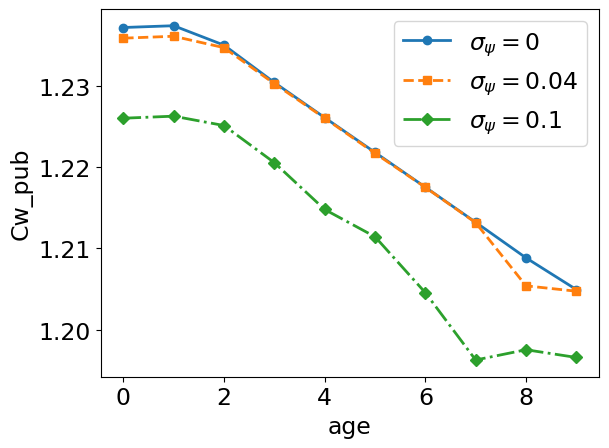

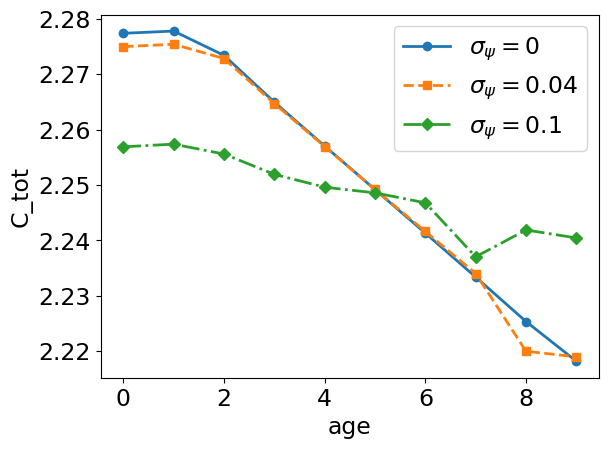

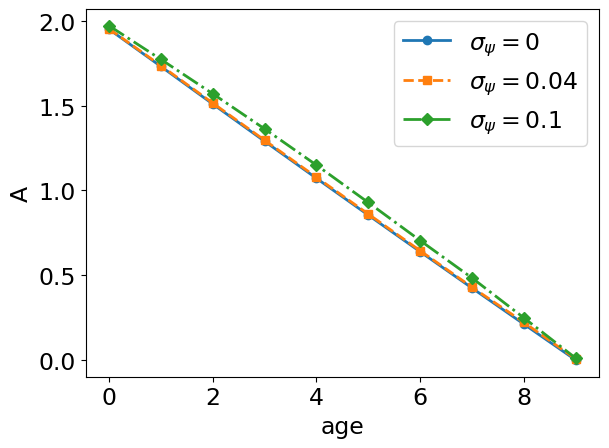

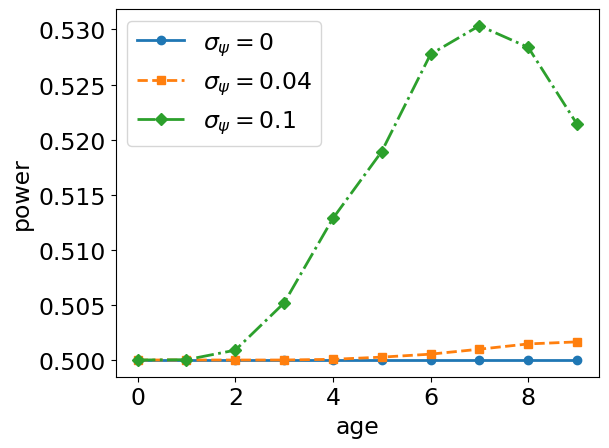

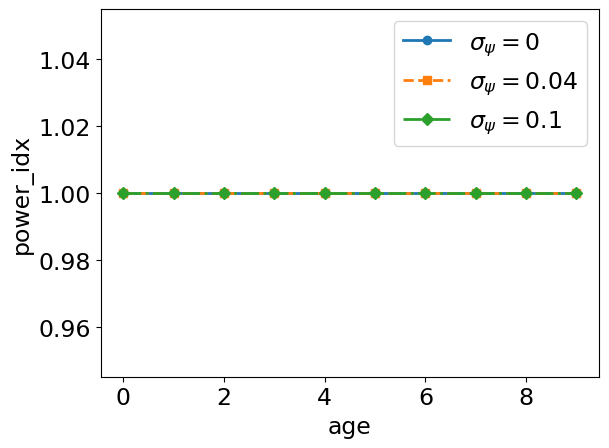

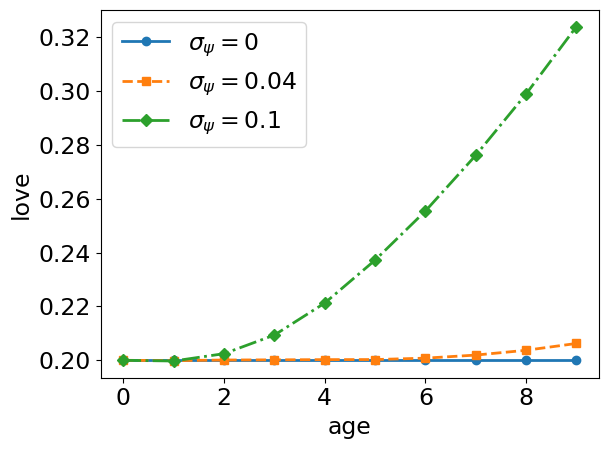

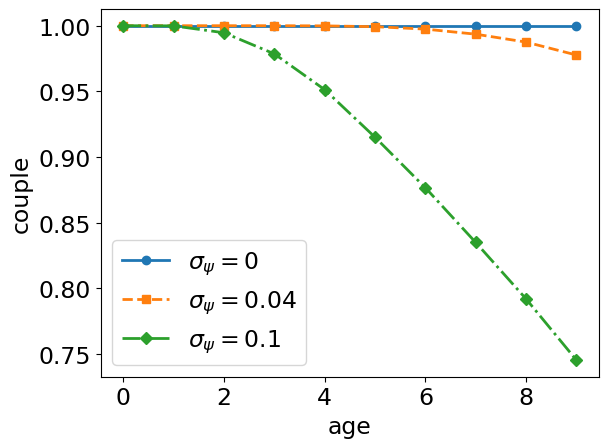

In [5]:
var_list = ('Cw_priv','Cm_priv','Cw_pub','C_tot','A','power','power_idx','love','couple')
model_list = ('model 1','model 2','model 3')

for init_power_idx in (1,10):
    for init_love in (0.0,0.2): 

            for i,name in enumerate(model_list):
                model = models[name]

                # show how starting of in a low bargaining power gradually improves
                model.sim.init_power_idx[:] = init_power_idx
                model.sim.init_love[:] = init_love 
                model.simulate()
                
            for var in var_list:

                fig, ax = plt.subplots()
                
                for i,name in enumerate(model_list):
                    model = models[name]

                    # pick out couples (if not the share of couples is plotted)
                    if var == 'couple':
                        nan = 0.0
                    else:
                        I = model.sim.couple<1
                        nan = np.zeros(I.shape)
                        nan[I] = np.nan

                    # pick relevant variable for couples
                    y = getattr(model.sim,var)        
                    y = np.nanmean(y + nan,axis=0)

                    ax.plot(y,marker=markers[i],linestyle=linestyles[i],linewidth=linewidth,label=model.spec['latexname']);
                    ax.set(xlabel='age',ylabel=f'{var}');

                plt.legend()

                fig_name = f'sim {var} init power{np.round(model.par.grid_power[init_power_idx],2)}_love{init_love}'
                plt.tight_layout()
                # plt.savefig(path+fig_name+'.pdf')

# Solution

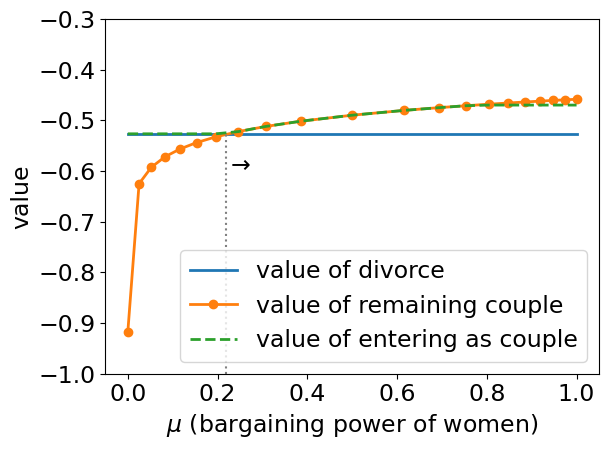

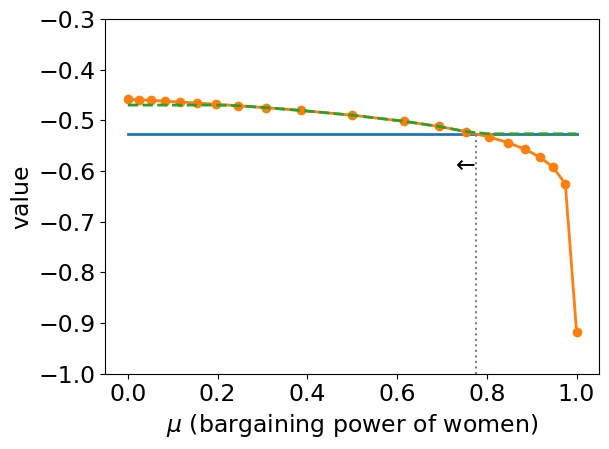

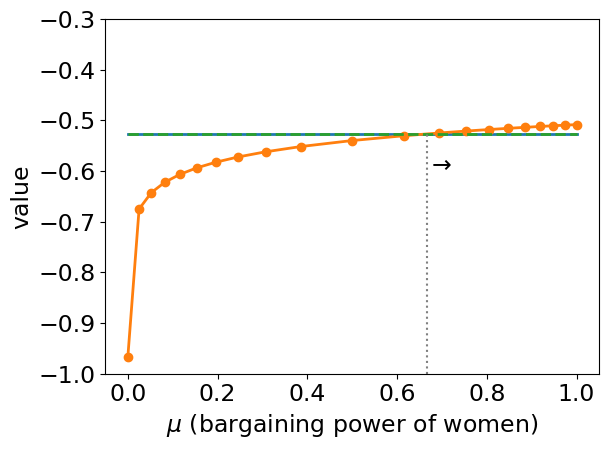

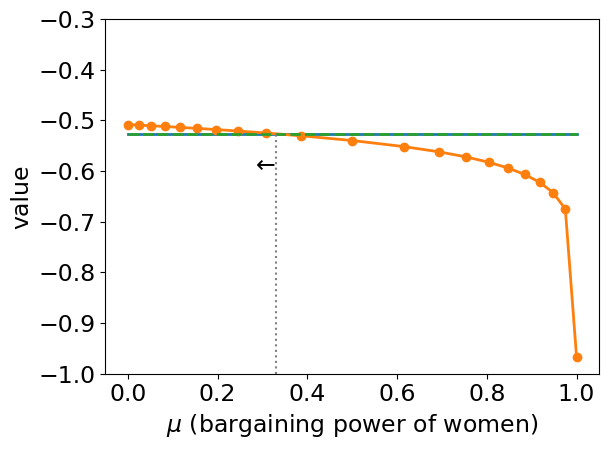

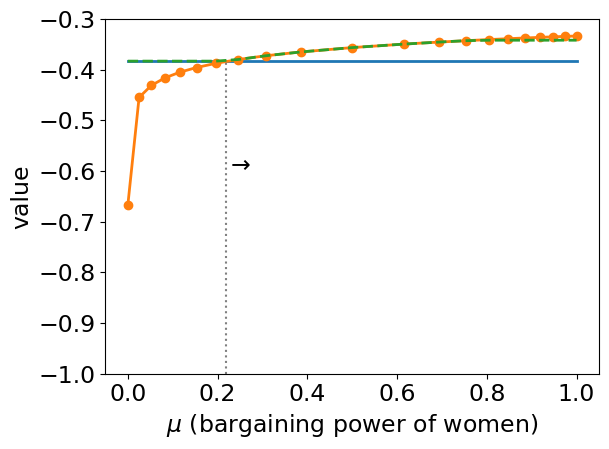

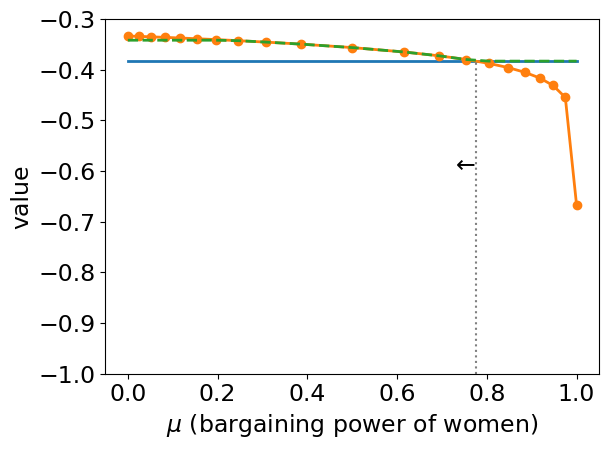

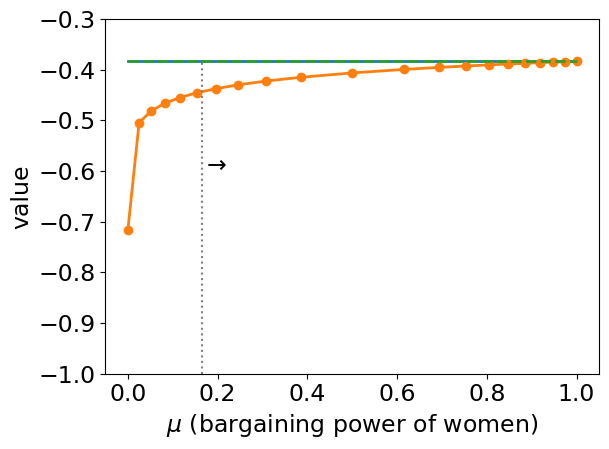

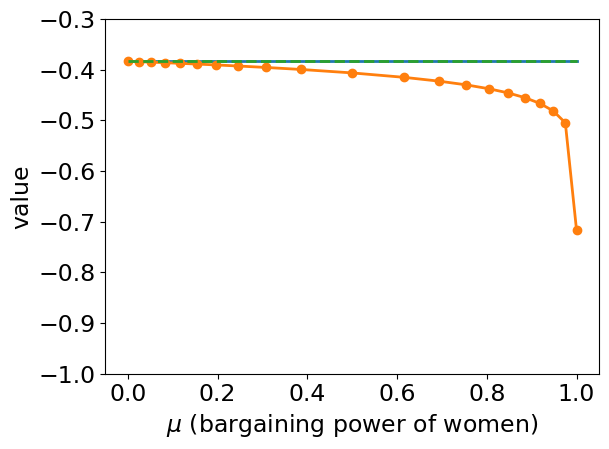

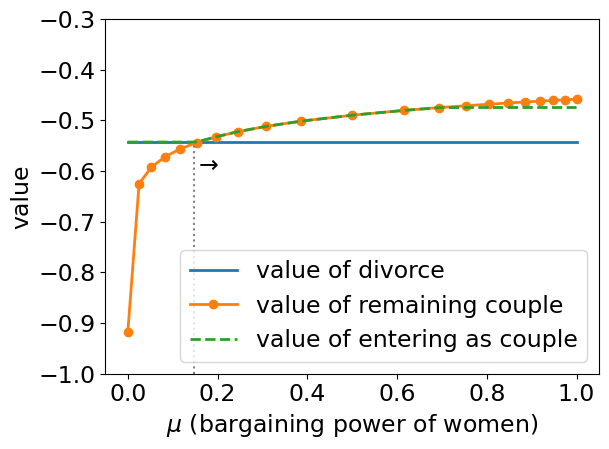

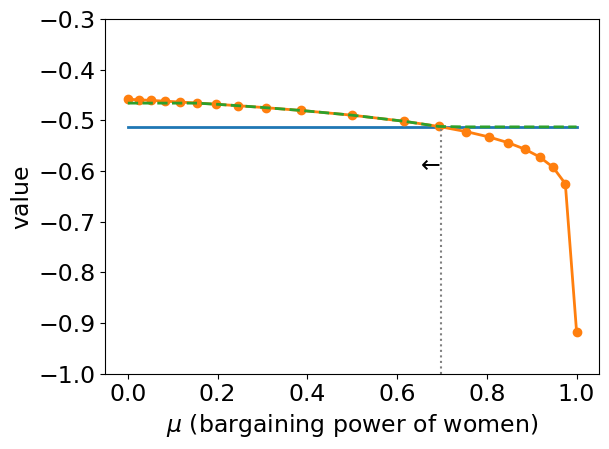

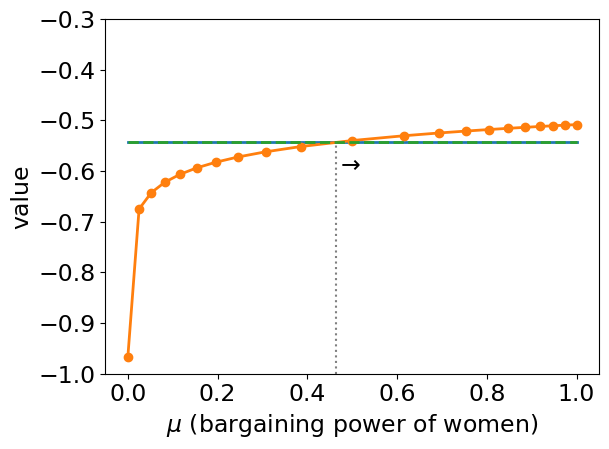

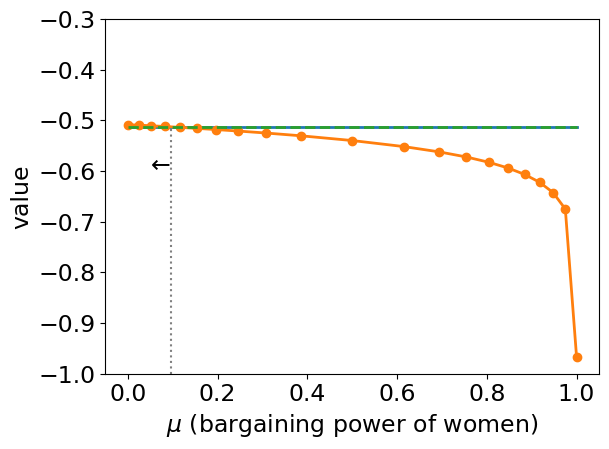

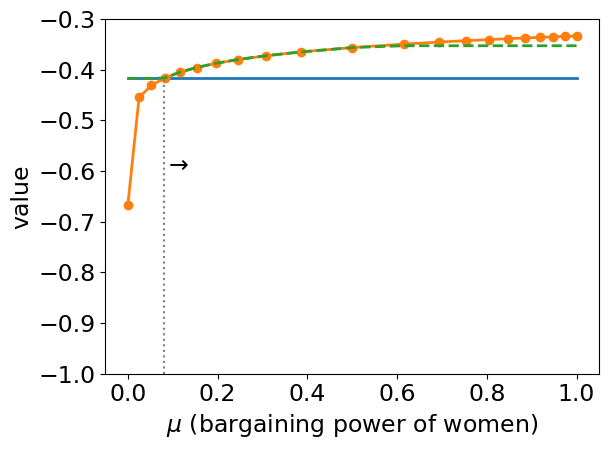

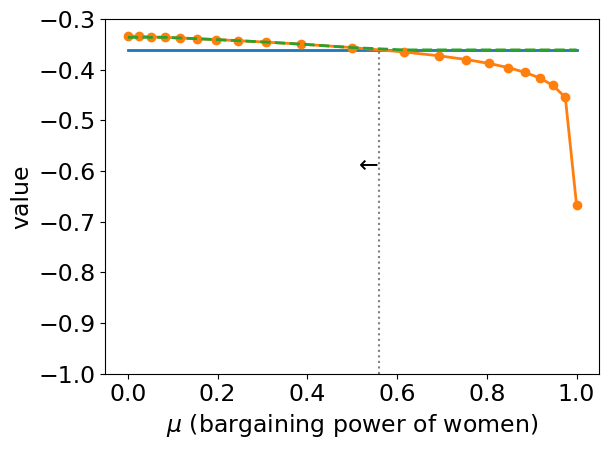

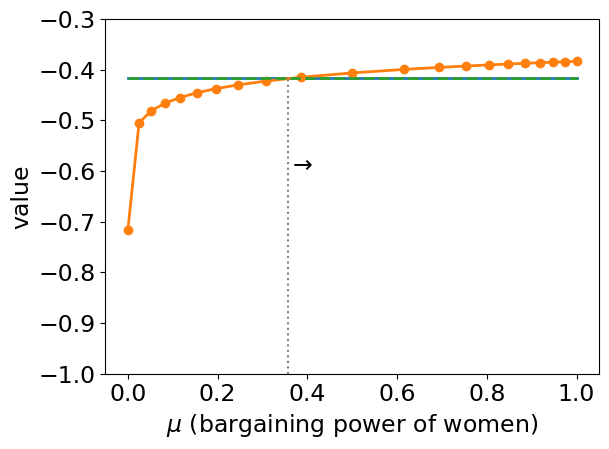

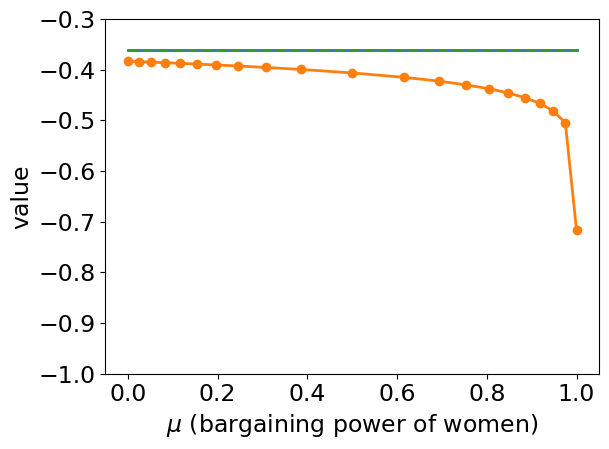

In [6]:
# Bargaining power updating
SAVE = False
for model_name in ('model 1','model 4'):
    model = models[model_name]
    par = model.par
    sol = model.sol
    
    for t in (par.T-1,):
        i = 0
        for iA in (5,45):
            for iL in (par.num_love//2,par.num_love//2 - 1):
                for sex in ('women','men'):
                    i += 1
                    fig, ax = plt.subplots()

                    # pick relevant values
                    if sex=='women':
                        V_single = sol.Vw_single[t,iA]*np.ones(par.num_power)
                        V_remain_couple = sol.Vw_remain_couple[t,:,iL,iA]
                        V_couple = sol.Vw_couple[t,:,iL,iA]
                    else:
                        V_single = sol.Vm_single[t,iA]*np.ones(par.num_power)
                        V_remain_couple = sol.Vm_remain_couple[t,:,iL,iA]
                        V_couple = sol.Vm_couple[t,:,iL,iA]

                    # plot values    
                    ax.plot(par.grid_power,V_single,linewidth=linewidth,label='value of divorce')
                    ax.plot(par.grid_power,V_remain_couple,marker='o',linewidth=linewidth,label='value of remaining couple')
                    ax.plot(par.grid_power,V_couple,linewidth=linewidth,linestyle='--',label='value of entering as couple')

                    # calculate corssing point
                    S = V_remain_couple - V_single
                    pos = np.int_(S > 0.0)
                    change = pos[1:] - pos[0:-1]
                    idx = np.argmax(np.abs(change))
                    if sex=='women':
                        idx = idx +1

                    denom = (par.grid_power[idx+1] - par.grid_power[idx]);
                    ratio = (S[idx+1] - S[idx])/denom;
                    power_zero = par.grid_power[idx] - S[idx]/ratio;
                    x = power_zero
                    
                    if x>0 and x <1:
                        ymin = -1.0
                        if t<par.T-1:
                            ymin = -5.0
                        ax.vlines(x=x, ymin=ymin, ymax=V_single[idx], color='gray',linestyle=':')

                        if t==par.T-1: 
                            if sex=='women':
                                ax.text(x,-0.6,'$\\rightarrow$',ha='left')
                            else:
                                ax.text(x,-0.6,'$\\leftarrow$',ha='right')

                    if t==par.T-1: ax.set(ylim=[-1.0, -0.3],xlabel='$\mu$ (bargaining power of women)',ylabel='value')

                    if i==1: plt.legend();

                    fig_name = f'sol bargaining {model_name} {sex} t{t}_love{np.round(par.grid_love[iL]):1.2f}_A{np.round(par.grid_A[iA]):1.2f}'
                    plt.tight_layout()
                    if SAVE: plt.savefig(path+fig_name+'.pdf')

# Policy functions

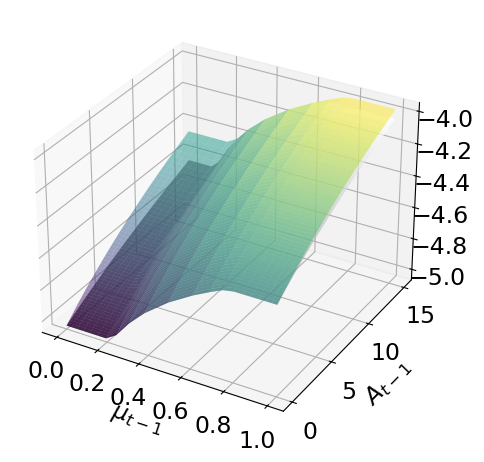

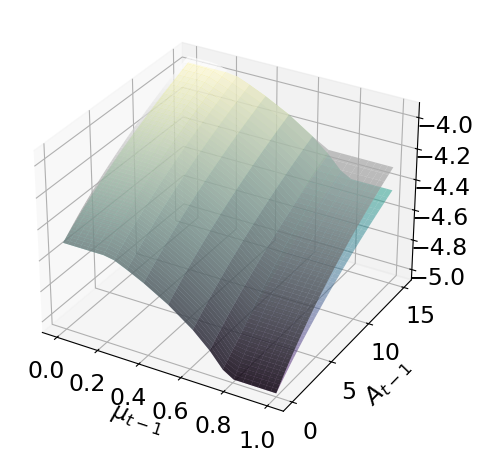

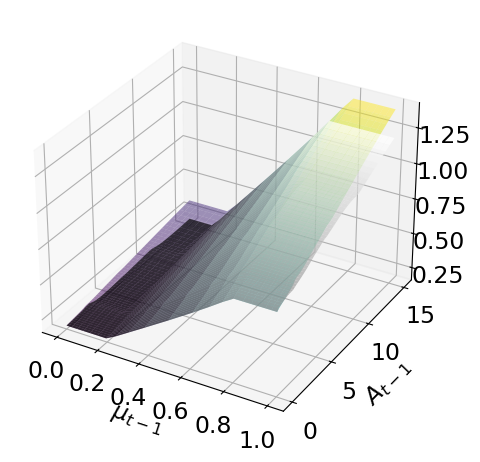

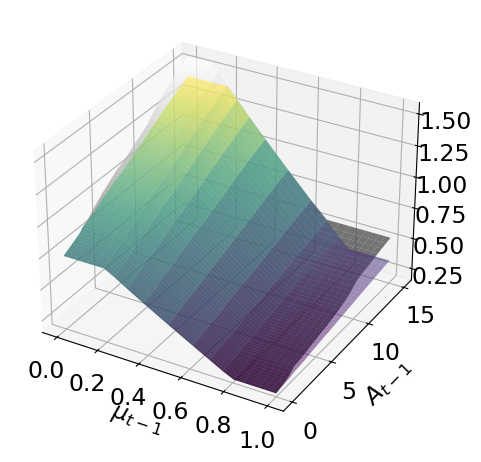

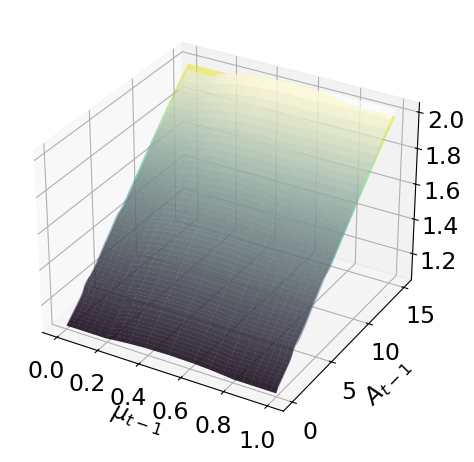

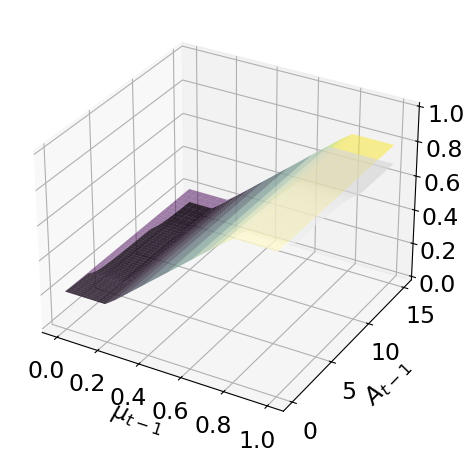

In [7]:
SAVE = False
cmaps = ('viridis','gray')
model_list = ('model 1','model 4')
t = 0 #par.T-1 -1

par = models['model 1'].par
X, Y = np.meshgrid(par.grid_power, par.grid_A,indexing='ij')

for iL in (par.num_love//2,): 
    for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):

        fig = plt.figure()
        ax = plt.axes(projection='3d')
        
        for i,name in enumerate(model_list):
            model = models[name]
        
            Z = getattr(model.sol,var)[t,:,iL,:]
            
            alpha = 0.5 if name=='model 1' else 0.7
            ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap=cmaps[i], edgecolor='none',alpha=alpha);
            
            if var == 'power': 
                
                ax.set(zlim=[0.0,1.0])
            
            ax.set(xlabel='$\mu_{t-1}$',ylabel='$A_{t-1}$');
            
        fig_name = f'sol {var} t{t}_love{np.round(par.grid_love[iL]):1.2f}'
        plt.tight_layout()
        if SAVE: plt.savefig(path+fig_name+'.pdf')